1. load sentence level propaganda dataset, generate train/validation/test set

In [9]:
#!/usr/bin/env python3
# -*- coding:utf-8 -*-
import os
import json
import re
import csv
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix,f1_score,roc_auc_score,roc_curve
import matplotlib.pyplot as plt
import math
np.random.seed(1)

In [10]:
def load_propaganda_task2():
    '''
    output:[[sentence, label]]
    '''
    global_sentence_label = list()
    
    tesk_2_3_path = '../other_dict/tasks-2-3/train/'
    target_data_2_dirs = os.listdir(tesk_2_3_path)
    article_name_set = set()
    for file_name in target_data_2_dirs:
        article_name_set.add(file_name.split(".")[0])
    for index in list(article_name_set):
        text_name = tesk_2_3_path + index + '.txt'
        try:
            text = open(text_name, encoding='utf-8', mode='r')
        except:
            print('No such file or directory: ', text_name)
            continue
        label_name = tesk_2_3_path + index + '.task2.labels'
        try:
            label = open(label_name, encoding='utf-8', mode='r')
        except:
            print('No such file or directory: ', label_name)
            continue
        text = text.readlines()
        sentence_list = []
        for sentence in text:
            sentence_list.append(sentence)
        label = label.readlines()
        label_list = []
        for line in label:
            label_list.append(line)
        assert len(label_list)==len(sentence_list),"text name %s, len of text %d, \
                len of label %d"%(text_name, len(sentence_list), len(label_list))
        for index,sentence in enumerate(sentence_list):
            if "\tnon-propaganda" in label_list[index] and sentence.strip()!="":
                global_sentence_label.append([sentence,0])
            elif "\tpropaganda" in label_list[index] and sentence.strip()!="":
                global_sentence_label.append([sentence,1])
            else:
                continue
    return global_sentence_label
# load data
global_sentence_label = load_propaganda_task2()
np.random.shuffle(global_sentence_label)
# partition to positive/negative
global_sentence_label_positive = [pair for pair in global_sentence_label if pair[1]==1]
global_sentence_label_negative = [pair for pair in global_sentence_label if pair[1]==0][:3938]
print("num of sentence is %d"%(len(global_sentence_label)))
print("num of pos sentence is %d"%(len(global_sentence_label_positive)))
print("num of neg sentence is %d"%(len(global_sentence_label_negative)))
# shuffle and partition to train/validation/test
np.random.shuffle(global_sentence_label_negative)
np.random.shuffle(global_sentence_label_positive)

train_dataset = global_sentence_label_negative[:int(len(global_sentence_label_negative)*0.8)]
train_dataset.extend(global_sentence_label_positive[:int(len(global_sentence_label_positive)*0.8)])

validation_dataset = global_sentence_label_negative[int(len(global_sentence_label_negative)*0.8):int(len(global_sentence_label_negative)*0.9)]
validation_dataset.extend(global_sentence_label_positive[int(len(global_sentence_label_negative)*0.8):int(len(global_sentence_label_negative)*0.9)])

test_dataset = global_sentence_label_negative[int(len(global_sentence_label_negative)*0.9):]
test_dataset.extend(global_sentence_label_positive[int(len(global_sentence_label_positive)*0.9):])
print("num of train %d"%(len(train_dataset)))
print("num of validation %d"%(len(validation_dataset)))
print("num of test %d"%(len(test_dataset)))

num of sentence is 14263
num of pos sentence is 3938
num of neg sentence is 3938
num of train 6300
num of validation 788
num of test 788


In [11]:
def load_dict(dict_path):
    word_set = set()
    dict_text = open(dict_path, encoding='utf-8', mode='r')
    for line in dict_text:
        if line.strip()!="":
            word =line.split(",")[0]
            word_set.add(word)
    return word_set
def word_num_in_dict(sentence, word_set):
    try:
        word_list = sentence.strip().split(" ")
    except:
        print(sentence)
    word_num = 0
    for word in word_list:
        if word in word_set:
            word_num += 1
    return word_num
def build_feature_matrix_and_label(dataset,dict_names,dict_path):
    num_sample = len(dataset)
    num_feature = len(dict_names)
    feature_matrix = np.zeros((num_sample, num_feature))
    label = np.zeros((num_sample,))
    for i in range(num_sample):
        for j in range(num_feature):
            if 'propaganda' in dict_names[j]:
                dict_path='./result_fake_true_week5/'
            else:
                dict_path="./result_fake_true_after_reduce_stopwords/"
            feature_matrix[i,j] = word_num_in_dict(dataset[i][0], load_dict(dict_path + dict_names[j] + "_words.csv"))
        label[i] = dataset[i][1]
    return feature_matrix,label
def build_feature_matrix_new_one_dict(dataset,dict_name,dict_path):
    if 'propaganda' in dict_name:
        dict_path='./result_fake_true_week5/'
    else:
        dict_path="./result_fake_true_after_reduce_stopwords/"
    word_list = list(load_dict(dict_path+dict_name+ "_words.csv"))
    num_sample = len(dataset)
    num_feature = len(word_list)
    feature_matrix = np.zeros((num_sample, num_feature))
    for i in range(len(dataset)):
        for j,word in enumerate(word_list):
            if word in dataset[i][0]:
                feature_matrix[i][j]=1
    return(feature_matrix)
#dict_names = ['fake_persuasive','fake_sentiment','fake_subjectivity','fake_technical','fake_all',
#              'true_persuasive','true_sentiment','true_subjectivity','true_technical','true_all']
dict_names = ['fake_persuasive','fake_sentiment','fake_subjectivity','fake_technical','fake_all',
              'true_persuasive','true_sentiment','true_subjectivity','true_technical','true_all']
dict_path = "./result_fake_true_after_reduce_stopwords/"
train_feature_matrix, train_label = build_feature_matrix_and_label(train_dataset, dict_names, dict_path)
validation_feature_matrix, validation_label = build_feature_matrix_and_label(validation_dataset, dict_names, dict_path)
test_feature_matrix, test_label = build_feature_matrix_and_label(test_dataset, dict_names, dict_path)

In [12]:
# one-hot feature
for dict_name in dict_names:
    train_feature_matrix=np.hstack((build_feature_matrix_new_one_dict(train_dataset,dict_names[0],dict_path),train_feature_matrix))
    validation_feature_matrix=np.hstack((build_feature_matrix_new_one_dict(validation_dataset,dict_names[0],dict_path),validation_feature_matrix))
    test_feature_matrix=np.hstack((build_feature_matrix_new_one_dict(test_dataset,dict_names[0],dict_path),test_feature_matrix))

In [13]:
print("shape",train_feature_matrix.shape, train_label.shape, test_feature_matrix.shape, test_label.shape,validation_feature_matrix.shape,validation_label.shape)

shape (6300, 1140) (6300,) (788, 1140) (788,) (788, 1140) (788,)


train and evaluate

The train accuracy score of rf is : 0.596825
The test accuracy score of rf is : 0.555838
confusion matrix is  [[221 173]
 [177 217]]
[[0.56091371 0.43908629]
 [0.44923858 0.55076142]]


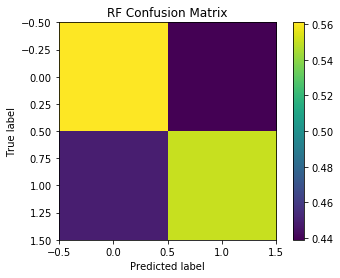

In [14]:
#gbdt, train and tune parameter
gbdt = GradientBoostingClassifier(max_depth=4,
                                  random_state=0,
                                  min_samples_split=5,
                                  learning_rate=0.01,
                                  n_estimators=30,
                                  subsample=0.8)
rf = gbdt.fit(train_feature_matrix, train_label)
val_score_rbf = gbdt.score(train_feature_matrix, train_label)
print("The train accuracy score of rf is : %f" % val_score_rbf)
test_score_rbf = gbdt.score(test_feature_matrix, test_label)
print("The test accuracy score of rf is : %f" % test_score_rbf)
predict_label = gbdt.predict(test_feature_matrix)
# confusion matrix 
def plot_confusion_matrix(cm, title):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    
    plt.imshow(cm)    
    print(cm)
    plt.title(title)    
    plt.colorbar()
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')
cm = confusion_matrix(test_label, predict_label)
print("confusion matrix is ", cm)
plot_confusion_matrix(cm, "RF Confusion Matrix")

In [15]:
#gbdt train again and predict
train_feature_matrix = np.vstack((validation_feature_matrix,train_feature_matrix))
train_label = np.concatenate((validation_label,train_label))
print(train_feature_matrix.shape, train_label.shape)

(7088, 1140) (7088,)


The train accuracy score of rf is : 0.589588
The test accuracy score of rf is : 0.558376
confusion matrix is  [[217 177]
 [171 223]]
[[0.55076142 0.44923858]
 [0.43401015 0.56598985]]


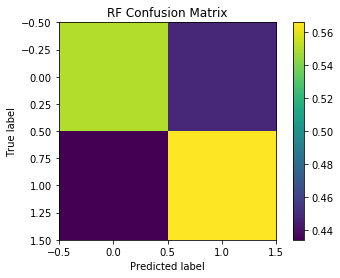

In [16]:
#gbdt train again and predict
gbdt = GradientBoostingClassifier(max_depth=4,
                                  random_state=0,
                                  min_samples_split=5,
                                  learning_rate=0.01,
                                  n_estimators=30,
                                  subsample=0.8)
rf = gbdt.fit(train_feature_matrix, train_label)
val_score_rbf = gbdt.score(train_feature_matrix, train_label)
print("The train accuracy score of rf is : %f" % val_score_rbf)
test_score_rbf = gbdt.score(test_feature_matrix, test_label)
print("The test accuracy score of rf is : %f" % test_score_rbf)
predict_label = gbdt.predict(test_feature_matrix)
# confusion matrix 
def plot_confusion_matrix(cm, title):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]   
    plt.imshow(cm)   
    print(cm)
    plt.title(title)    
    plt.colorbar()
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')
cm = confusion_matrix(test_label, predict_label)
print("confusion matrix is ", cm)
plot_confusion_matrix(cm, "RF Confusion Matrix")